In [1]:
# notebook to compile all of the csvs into a single array
import os
import sys
import glob
import pandas as pd
import numpy as np
import subprocess

import pickle
import rmgpy.chemkin

import cantera as ct

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.offsetbox
%matplotlib inline

sys.path.append('/work/westgroup/harris.se/autoscience/reaction_calculator/database')
import database_fun


In [2]:
T = 830
P = 10

# Compile delays into one file

In [3]:
# Run this using tst_env instead of rmg_env if files don't already exist
mech_dirs = [
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240501',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/aramco',
]

N = 26
for m, mech_dir in enumerate(mech_dirs):
    
    sensitivity_dir = os.path.join(mech_dir, f'id_sensitivity_{T}K_{P}bar')
    compiled_delay_file = os.path.join(sensitivity_dir, 'compiled_delays.npy')
    if os.path.exists(compiled_delay_file):
        print(f'skipping compile process because file {compiled_delay_file} already exists')
        continue
    
    gas = ct.Solution(os.path.join(mech_dir, 'chem_annotated.yaml'))
    delays = np.zeros(len(gas.reactions()))
    
    delay_files = glob.glob(os.path.join(sensitivity_dir, 'reaction_delays_*'))
    for f in delay_files:
        start_index = int(f[-8:-4])
        print(start_index)
        delay_subset = np.load(f)
        assert len(delay_subset) == N or f == delay_files[-1]
        delays[start_index: start_index + len(delay_subset)] = delay_subset

    np.save(compiled_delay_file, delays)
    
    

skipping compile process because file /work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126/id_sensitivity_830K_10bar/compiled_delays.npy already exists
skipping compile process because file /work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240501/id_sensitivity_830K_10bar/compiled_delays.npy already exists
skipping compile process because file /work/westgroup/harris.se/autoscience/fuels/butane/official/aramco/id_sensitivity_830K_10bar/compiled_delays.npy already exists


# Compute sensitvities

In [4]:
with open('/work/westgroup/harris.se/autoscience/reaction_calculator/database/reverses.pickle', 'rb') as f:
    dups = pickle.load(f)


mech_dirs = [
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/aramco',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240501',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126',
]

M = 10


top_M_reactions = np.zeros((M, len(mech_dirs)))
top_M_sensitivities = np.zeros((M, len(mech_dirs)))

total_sensitivites = np.zeros((3500, len(mech_dirs)))

for m, mech_dir in enumerate(mech_dirs):
    chemkin = os.path.join(mech_dir, 'chem_annotated.inp')
    species_dict = os.path.join(mech_dir, 'species_dictionary.txt')
    species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin, species_dict)
    sensitivity_dir = os.path.join(mech_dir, f'id_sensitivity_{T}K_{P}bar')
    if not os.path.exists(os.path.join(mech_dir, 'ct2rmg_rxn.pickle')):
        RMG_TOOLS_DIR = '/home/harris.se/rmg/rmg_tools'
        subprocess.run(['python', os.path.join(RMG_TOOLS_DIR, 'ct2rmg_dict.py'), chemkin])

    with open(os.path.join(mech_dir, 'ct2rmg_rxn.pickle'), 'rb') as f:
        ct2rmg_rxn = pickle.load(f)

    compiled_delay_file = os.path.join(sensitivity_dir, 'compiled_delays.npy')
    base_delay = np.load(os.path.join(sensitivity_dir, 'base_reaction_delay.npy'))
    delays = np.load(compiled_delay_file)
    
    delays[delays == 0] = np.nan
    d_ln_tau = np.log(delays) - np.log(base_delay)
    delta = 0.1
    first_derivative = d_ln_tau / delta
    
    ######################## Get a union of the top M reactions for all 3 mechanisms
    my_sensitivities = first_derivative
    my_sensitivities[np.isnan(my_sensitivities)] = 0
    total_sensitivites[:len(my_sensitivities), m] = my_sensitivities

    # get the order
    abs_parameter_indices = np.arange(0, my_sensitivities.shape[0])
    abs_sensitivity_order = [x for _, x in sorted(zip(np.abs(my_sensitivities), abs_parameter_indices))][::-1]



    
    count = 0
    for j in range(2 * M):
        ct_index = abs_sensitivity_order[j]
        db_index = database_fun.get_unique_reaction_index(reaction_list[ct2rmg_rxn[ct_index]])

        if db_index in top_M_reactions[:count, m]:
            continue  # don't include 18 twice
            
        top_M_reactions[count, m] = db_index
        top_M_sensitivities[count, m] = my_sensitivities[ct_index]
        count += 1
        if count >= M:
            break

print('done')

done


In [5]:
# Use the lower-numbered version of the reaction if its reverse exists in the database
for m in range(len(mech_dirs)):
    for j in range(M):
        try:
            if dups[int(top_M_reactions[j, m])] and dups[int(top_M_reactions[j, m])] < int(top_M_reactions[j, m]):
                top_M_reactions[j, m] = dups[int(top_M_reactions[j, m])]
        except KeyError:
            pass

In [6]:
# reorder by absolute value

top_M_reactions_signed = np.zeros((M, len(mech_dirs)))
top_M_sensitivities_signed = np.zeros((M, len(mech_dirs)))


for i in range(len(mech_dirs)):
    parameter_indices = np.arange(0, M)
    final_sensitivity_order = [x for _, x in sorted(zip(top_M_sensitivities[:, i], parameter_indices))]
    
    
    for j in range(M):
        top_M_reactions_signed[j, i] = top_M_reactions[final_sensitivity_order[j], i]
        top_M_sensitivities_signed[j, i] = top_M_sensitivities[final_sensitivity_order[j], i]

In [7]:
# Get things ordered in terms of Aramco first, then RMG-7 then RMG-1

reaction_labels = []
set_of_reactions = []
for m in range(len(mech_dirs)):
    for j in range(M):
        if int(top_M_reactions_signed[j, m]) not in set_of_reactions:
            set_of_reactions.append(int(top_M_reactions_signed[j, m]))
            
            reaction_labels.append(database_fun.reaction2smiles(database_fun.index2reaction(int(top_M_reactions_signed[j, m]))))

new_top_M_sensitivities = np.zeros((len(set_of_reactions), len(mech_dirs)))
new_top_M_sensitivities[:M, 0] = top_M_sensitivities_signed[:, 0]

for m in range(1, len(mech_dirs)):
    for j in range(M):
        new_index = set_of_reactions.index(int(top_M_reactions_signed[j, m]))
        new_top_M_sensitivities[new_index, m] = top_M_sensitivities_signed[j, m]




# Fill in the zeros with the missing values

In [8]:
def get_reaction_index(db_index, reaction_list):
    ref_reaction = database_fun.index2reaction(db_index)
    
    for r in range(len(reaction_list)):
        if reaction_list[r].is_isomorphic(ref_reaction):
            return r
        
    return -1

alpha_mask = new_top_M_sensitivities == 0

for m in range(len(mech_dirs)):
    chemkin = os.path.join(mech_dirs[m], 'chem_annotated.inp')
    species_dict = os.path.join(mech_dirs[m], 'species_dictionary.txt')
    species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin, species_dict)
    with open(os.path.join(mech_dirs[m], 'ct2rmg_rxn.pickle'), 'rb') as f:
        ct2rmg_rxn = pickle.load(f)
    
    for j in range(len(set_of_reactions)):
        if new_top_M_sensitivities[j, m] == 0:
            rmg_idx = get_reaction_index(set_of_reactions[j], reaction_list)
            if rmg_idx >= 0:
                ct_index = next(key for key, value in ct2rmg_rxn.items() if value == rmg_idx)
                new_top_M_sensitivities[j, m] = total_sensitivites[ct_index, m]
            else:
                try:
                    revese_db_index = dups[set_of_reactions[j]]
                    if revese_db_index:
                        rev_rmg_idx = get_reaction_index(revese_db_index, reaction_list)
                        rev_ct_index = next(key for key, value in ct2rmg_rxn.items() if value == rev_rmg_idx)
                        new_top_M_sensitivities[j, m] = -total_sensitivites[rev_ct_index, m]
                except KeyError:
                    pass
            


In [9]:
# change the order one more time to go by average promoting to average inhibiting

# average_value = np.mean(new_top_M_sensitivities, axis=1)

aramco_weight = 0.8
average_value = aramco_weight * new_top_M_sensitivities[:, 0] + \
                0.5 * (1.0 - aramco_weight) * new_top_M_sensitivities[:, 1] + \
                0.5 * (1.0 - aramco_weight) * new_top_M_sensitivities[:, 2]

M_indices = np.arange(0, new_top_M_sensitivities.shape[0])

final_index_order = [x for _, x in sorted(zip(average_value, M_indices))]
 
final_top_M_sensitivities = np.zeros(new_top_M_sensitivities.shape)
final_reaction_labels = []
final_set_of_reactions = []
final_alpha_mask = np.zeros(new_top_M_sensitivities.shape)



for m in range(final_top_M_sensitivities.shape[0]):
    final_reaction_labels.append(reaction_labels[final_index_order[m]])
    final_top_M_sensitivities[m, :] = new_top_M_sensitivities[final_index_order[m], :]
    final_alpha_mask[m, :] = alpha_mask[final_index_order[m], :]
    final_set_of_reactions.append(set_of_reactions[final_index_order[m]])
    


In [10]:
# make reaction images for y axis labels
img_files = []
for rxn_idx in final_set_of_reactions:
    rxn_file = f'r{rxn_idx:06}.png'
    r = database_fun.index2reaction(rxn_idx)
    r.draw(rxn_file)
    img_files.append(rxn_file)

In [11]:
calculated = [
    288, 4724, 5046, 4778, 4736, 4729, 4728, 50, 5047,  # failed on 4752, 4732, 945, 518
    4779, 286, 246, 5596, 808, 915, 4737, 5446,
    324, 4738, 7841, 804, 809, 4721, 245, 213, 289,
    422, 805, 4796, 1077, 1111, 1706, 4917, 417, 319,
    313, 278, 314, 52, 5056, 405, 5102, 521, 404, 410,
    4733, 296, 321, 301, 280, 253, 459, 1736, 1778, 299,
]

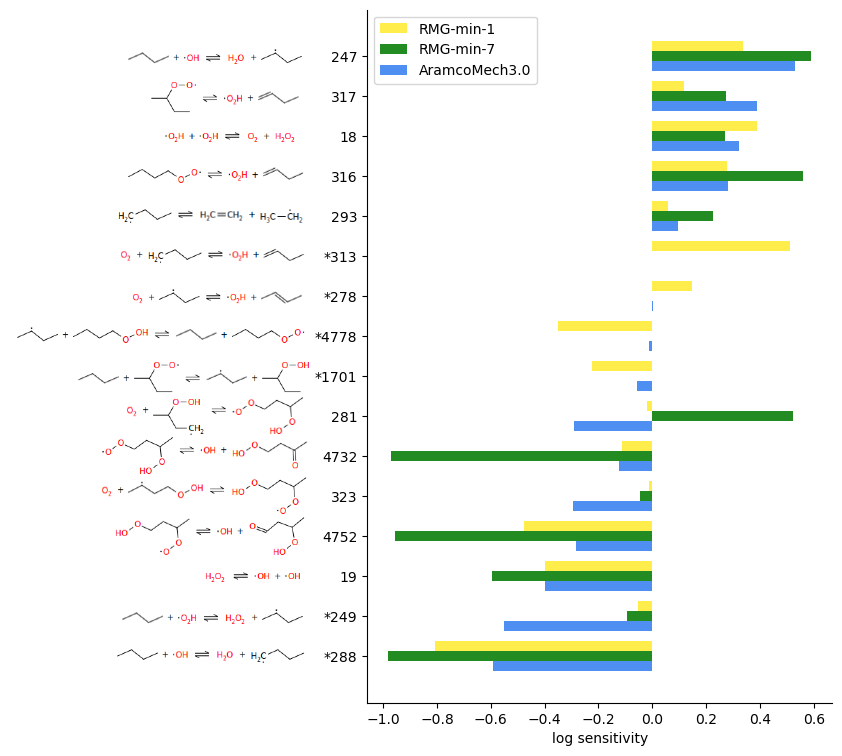

In [12]:
# plot the thing
plt.figure(figsize=(6, 9))
fig_labels = ['AramcoMech3.0', 'RMG-min-7', 'RMG-min-1']
width = 0.25


start_color = (1.0, 0.9, 0.0)
end_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
aramco_color = (0.18627451, 0.48823529, 0.94117647)
colors = sns.blend_palette([start_color, end_color], n_colors=7, as_cmap=False, input='rgb')

colors[1] = colors[6]
colors[2] = colors[0]
colors[0] = aramco_color


numbers = [x for x in np.arange(len(set_of_reactions))]
# for m in range(len(mech_dirs)):
alphas = [0.85, 1.0, 0.7]
for m in [2, 1, 0]:
    for k in range(len(set_of_reactions)):
        label = '_nolegend_'
        if k == 0:
            label = fig_labels[m]
        
        plt.barh(k + width * (m - 1.5), final_top_M_sensitivities[k, m], label=label, height=width, align='edge',
                alpha=alphas[m], color=colors[m])
#         plt.barh(k + width * (m - 1.5), new_top_M_sensitivities[k, m], label=label, height=width, align='edge',
#                 alpha=alpha, color=colors[m])

# plt.yticks(np.arange(len(set_of_reactions)), [str(int(x)) for x in set_of_reactions])
plt.yticks(np.arange(len(final_set_of_reactions)), final_reaction_labels) # <----- this for SMILES
plt.yticks(np.arange(len(final_set_of_reactions)), ['' for f in final_reaction_labels]) # <----- this for SMILES
plt.legend()
plt.xlabel('log sensitivity')
ax1 = plt.gca()

# plt.sca(ax1)
my_ytick_labels = [str(int(x)) for x in final_set_of_reactions]

for i in range(len(my_ytick_labels)):
    if int(my_ytick_labels[i]) in calculated or dups[int(my_ytick_labels[i])] in calculated:
        my_ytick_labels[i] = '*' + my_ytick_labels[i]

plt.yticks(np.arange(len(final_set_of_reactions)), my_ytick_labels)

ax1.spines[['right', 'top']].set_visible(False)

extra_padding = [0 for f in final_set_of_reactions]
extra_padding[final_set_of_reactions.index(4778)] = 0.05
extra_padding[final_set_of_reactions.index(19)] = -0.03

W = 300
plt_width = ax1.get_xlim()[1] - ax1.get_xlim()[0]
for k in range(len(ax1.get_yticks())):

    img = mpimg.imread(img_files[k])
    y_val = ax1.get_yticks()[k]
    
    img_width = img.shape[1]
    
    
    zoom = min(W / img_width, 0.50)
    imagebox = matplotlib.offsetbox.OffsetImage(img, zoom=zoom)
    
    
    x_val = -1.38 - extra_padding[k] - img_width * zoom / plt_width / W
    
    ab = matplotlib.offsetbox.AnnotationBbox(imagebox, (-1.0, y_val), xybox=(x_val, y_val), frameon=False)
    ax1.add_artist(ab)
